["On the Surprising Behavior of Distance Metrics in High Dimensional Spaces"](https://www.semanticscholar.org/paper/On-the-Surprising-Behavior-of-Distance-Metrics-in-Aggarwal-Hinneburg/88fc7fc6ed73db6251967cfe40507a92008e5949)という論文を読んで面白かったのでまとめておきます。

$d$次元空間の立方体$(0,1)^d$中に分布する確率変数$X_d$を考えます。例えばモノクロ画像なんかは正規化すれば今考えてる確率変数になるでしょう。今$(0, 1)$上の任意の分布$F$を考え$F^d$を確率分布とする$X_d$から$n$個のサンプルが得られたとします。サンプルにおける$L_k$ノルムの最大値を$Dmax^k_d$、最小値を$Dmin^k_d$とすると、$F$と$k$のみに依存する定数$C_k$が存在して

$$
C_k \leq \underset{d \rightarrow \infty}{\lim}{\rm E}\left[\frac{Dmax^k_d - Dmin^k_d}{d^{\frac{1}{k}-\frac{1}{2}}}\right] \leq (n-1)C_k
$$

が成り立ちます。ここで${\rm E}[X]$は$X$の期待値を表します。

つまりデータの存在する次元が上がるにつれて原点に近いものと遠いものの差が変化するスピードは$d^{\frac{1}{k}-\frac{1}{2}}$ぐらいになるということです。証明を読めば分かりますが、差の漸近的な振る舞いを決める$d^{\frac{1}{k}-\frac{1}{2}}$の$\frac{1}{2}$は中心極限定理から出てきます。もし$k \geq 3$であればこれは減衰するので、どんどん近いデータと遠いデータの間に差がなくなってくるということを意味しています。これは原点を任意の注目する点に置き換えて考えれば、例えばサンプルの近傍を考えるときに次元が高くなると遠いものと近いものの区別がどんどんつかなくなっていくことを表しています。一方もし$k=2$であればこの差は一定に落ち着き、$k=1$であれば（期待通り？）大きくなってくれます。

次元が高くなれば立方体の対角線の長さも大きくなるので直感的には最大値と最小値の差はどんどん大きくなっていきそうですが、同時に、すべての次元で0付近の値が出る確率や1付近の値が出る確率は次元が高くなるとどんどん小さくなるので、差の期待値がどう振る舞うかはこれらの綱引きになりそうなことは直感的には分かります。この綱引きの勝敗が距離の測り方で決まるのは面白いですね。

この挙動を実際に確かめてみましょう。

In [1]:
import Control.Monad (replicateM)
import System.Random.MWC


-- | 確率変数
type RVar a = GenIO -> IO a


-- | n個のリストの確率変数
randomNs :: Int -> RVar a -> RVar [a]
randomNs n x = sample n
  where
    sample 0 _ = pure []
    sample n g = do
      a <- x g
      as <- sample (n-1) g
      pure (a:as)


-- L_kノルム
lk :: Int -> [Double] -> Double
lk k xs = sum (map (^k) xs) ** (1.0 / fromIntegral k)


-- | Dmax^k_d - Dmin^k_d
diameter :: Int -- 直径計算のためのサンプルを生成する数
         -> Int -- L_kノルムのk
         -> Int -- 次元d
         -> RVar Double
diameter n k d g =
  let xs g = replicateM d (uniformR (0.0, 1.0) g)
   in do
     xss <- randomNs n xs g
     let ds = map (lk k) xss
     pure $ maximum ds - minimum ds


-- | 確率変数の期待値
expected :: Fractional a
         => Int    -- 期待値を計算するのに用いるサンプル数
         -> RVar a -- 期待値を求める確率変数
         -> RVar a -- 期待値の確率変数
expected n x g = do
  as <- randomNs n x g
  pure $ sum as / fromIntegral n

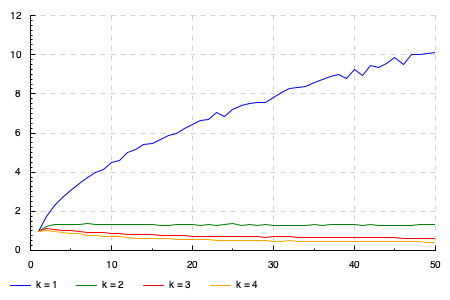

In [2]:
import Data.Traversable (forM)
import Graphics.Rendering.Chart.Easy

ds :: [Int]
ds = [1..50]

withSystemRandom $ \gen -> do
  diff1 <- forM ds $ \d -> expected 100 (diameter 100 1 d) gen
  diff2 <- forM ds $ \d -> expected 100 (diameter 100 2 d) gen
  diff3 <- forM ds $ \d -> expected 100 (diameter 100 3 d) gen
  diff4 <- forM ds $ \d -> expected 100 (diameter 100 4 d) gen
  pure . toRenderable $ do
      plot (line "k = 1" [zip ds diff1])
      plot (line "k = 2" [zip ds diff2])
      plot (line "k = 3" [zip ds diff3])
      plot (line "k = 4" [zip ds diff4])

次元を増やすにつれて$k=1$の時は最小値と最大値の差が大きくなっていきますが、$k=2$の場合は一定に落ち着き、$k=3,4$の場合は差がどんどんなくなっていき、この傾向は$k$が大きければより強いことが分かります。

論文ではもう一つ面白い式が導かれています。先程の不等式は最大値と最小値の差についてでしたが、今度は比についてです。

$$
\underset{d \rightarrow \infty}{\lim} {\rm E}\left[\sqrt{d}\left(\frac{Dmax^k_d}{Dmin^k_d} - 1\right)\right] = C\sqrt{\frac{1}{2k+1}}
$$

ただしこの式は$F$が一様分布でサンプルが2点である時という制約がついています。この式が示唆するのは最大値と最小値の比は$\frac{1}{\sqrt{d}}$ぐらいのスピードで1に近づいていくということで、この挙動は$k$が1,2のときでも変わりません。